# 薛定谔方程本征值与本征态问题（有限离散法）
$$ i\hbar \partial_t \psi = -\frac{\hbar^2}{2m} \nabla^2 \psi + V(x)\psi$$
选取谐振子势$$ V(x) = \frac{m\omega^2 x^2}{2}$$
将空间作离散化，其中nabla算符变为
$$ \nabla^2 \psi(x) = \frac{\psi(x_{i+1})+\psi(x_{i-1})-2\psi(x_i)}{\Delta x^2}$$
则$$\hat{H}\psi(x_i)= -\frac{\hbar^2}{2m}\frac{\psi(x_{i+1})+\psi(x_{i-1})-2\psi(x_i)}{\Delta x^2} + V(x_i)\psi(x_i) $$

In [90]:
#定义初始化参数
dx =  2e-2
Lx = 10
x_range = -Lx:dx:Lx
N = length(x_range)
ħ = 1
m = 1
ω = 1;

定义外势为谐振子势

In [91]:
V = @. 0.5*ω^2*x_range^2;

In [92]:
H_mat = zeros(N,N);

In [93]:
DisFactor = ħ^2/(dx^2*m)
#为哈密顿算符的矩阵赋值
for i = 2:N-1
    H_mat[i,i] = V[i] + DisFactor
    H_mat[i,i+1] = -DisFactor/2
    H_mat[i,i-1] = -DisFactor/2
end
#手动设置边界点，此处设为周期边界条件
H_mat[1,1] = V[1] + DisFactor
H_mat[1,2] = -DisFactor/2
H_mat[1,N] = -DisFactor/2
H_mat[N,N-1] = -DisFactor/2
H_mat[N,N] = V[N] + DisFactor
H_mat[N,1] = -DisFactor/2;

In [94]:
using LinearAlgebra

In [95]:
wavefuncs = eigvecs(H_mat);

In [96]:
funcvals = eigvals(H_mat);

In [97]:
funcvals;

In [72]:
using Plots

In [73]:
pyplot()

Plots.PyPlotBackend()

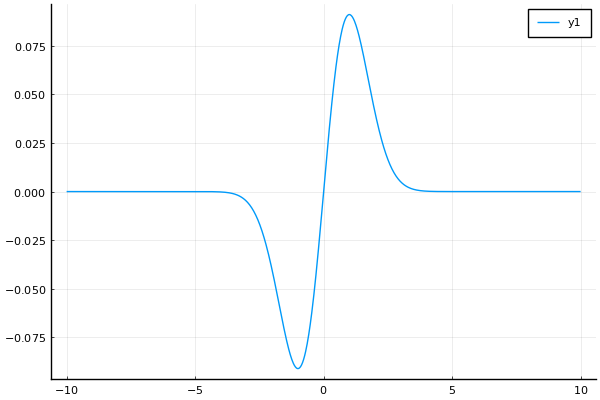

In [98]:
plot(x_range,-wavefuncs[:,2])

# 薛定谔方程实时演化

In [566]:
psi0s = -wavefuncs[:,1];

## 对波函数进行一段位移

In [132]:
psi_shift= zeros(ComplexF64,N)
for i =1:N
    psi_shift[i] = psi0[mod(i+20,N)+1]
end

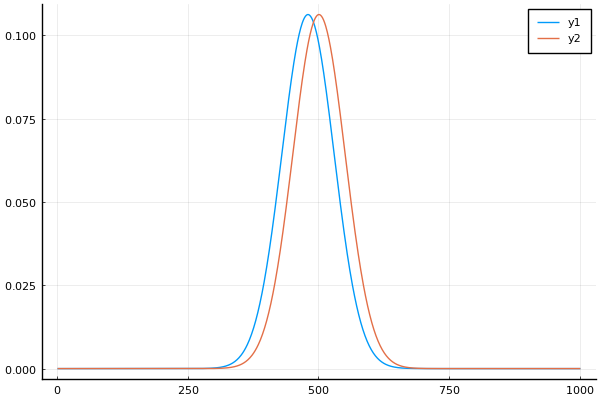

In [105]:
plot([real.(psi_shift),psi0])

### 定义哈密顿演化函数，直接的欧拉法会迅速发散，此处使用四阶龙格库塔法

In [121]:
function evolution_H(H_mat,psi;dt = 0.0001,times=1)
    for i =1:times
        k1 = - 1im* (H_mat*psi)
        k2 = - 1im* (H_mat*(psi+0.5*dt*k1))
        k3 = - 1im* (H_mat*(psi+0.5*dt*k2))
        k4 = - 1im* (H_mat*(psi+dt*k3))
        Slope = (k1+2*k2+2*k3+k4)/6
        psi = psi + dt*Slope
    end
    psi
end

evolution_H (generic function with 1 method)

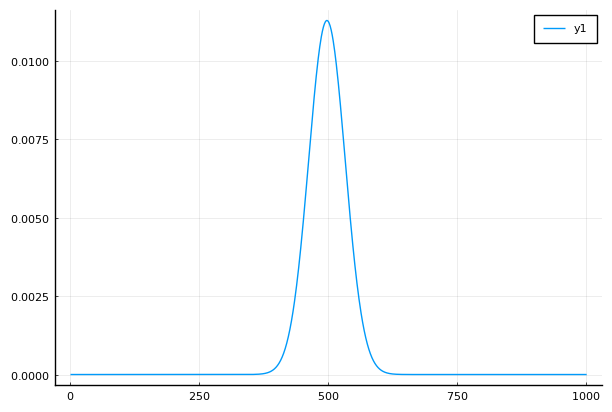

┌ Info: Saved animation to 
│   fn = /home/richard/Documents/Notebooks/ExamplesFolder/tmp.gif
└ @ Plots /home/richard/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/home/richard/Documents/Notebooks/ExamplesFolder/tmp.gif")
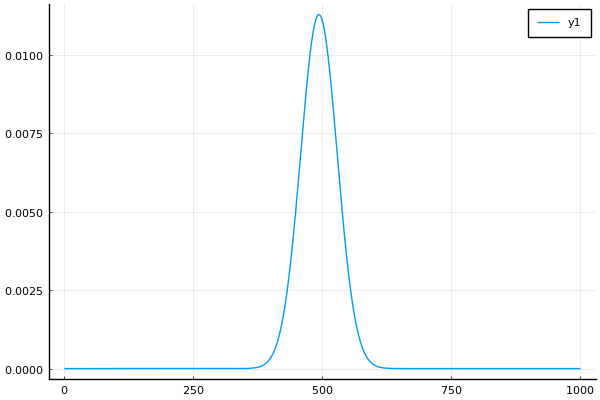

In [134]:
@gif for i = 1:500
    global psi_shift = evolution_H(H_mat,psi_shift,times = 100,dt=5e-4)
    plot(abs2.(psi_shift));
end

# 傅里叶变换方法求解薛定谔方程
$$i\hbar \partial_t \psi(x,t) = -\frac{\hbar^2}{2m} \nabla^2 \psi(x,t) + V(x)\psi(x,t)$$
将空间部分作傅里叶变换到动量空间
$$\psi(x,t) = \frac{1}{2\pi}\int e^{-ikx} \psi(k,t) dk$$
则动能项在傅里叶变换下形式为
$$ \frac{-\hbar^2\nabla^2}{2m} \psi(x,t) = \frac{1}{2\pi}\int \frac{\hbar^2 k^2}{2m}\psi(k,t) e^{-ikx}dk$$

In [135]:
using FFTW

$$ \operatorname{DFT}(A)[k] = \sum_{n=1}^{\operatorname{length}(A)} \exp\left(-i\frac{2\pi(n-1)(k-1)}{\operatorname{length}(A)}\right)A[n]$$
我们记
$$\operatorname{length}(A) = L$$
划分格点最小周期为
$$k_{max} dx = 2\pi \\ 
k_{max} = \frac{2\pi N}{L}\\
dk = \frac{k_max}{N} = \frac{2\pi}{L}$$

In [717]:
Lx = 10
dx = 0.05
x_grid = collect(-Lx/2:dx:Lx/2)
N = length(x_grid)
dk = 2*pi/Lx
V = @. 0.5*ω^2*x_grid^2
V = fftshift(V)
k_grid = (collect(0:N-1).-N/2)*dk;
k_grid = fftshift(k_grid);

In [718]:
function Hamiltonia_F(psi,parMat)
    V = parMat["V"]
    psik = fft(psi)
    H_V = V.*psi
    E_kin = k_grid.^2/2
    H_momentum = ifft(E_kin.*psik)
    H_V.+H_momentum
end

Hamiltonia_F (generic function with 1 method)

In [719]:
parMat = Dict(["V"=>V,"imaginary_time_switch"=>true])
psi0 = rand(N);

In [720]:
function evolve_F(psi0,parMat;dt = 1e-5,times = 1000)
    imaginary_time_switch = parMat["imaginary_time_switch"]
    Dt = imaginary_time_switch ? -1 : -im
    psi = copy(psi0)
    for i = 1:times
        k1 = Hamiltonia_F(psi,parMat)
        k2 = Hamiltonia_F(psi+0.5*dt*k1,parMat)
        k3 = Hamiltonia_F(psi+0.5*dt*k2,parMat)
        k4 = Hamiltonia_F(psi+dt*k3,parMat)
        Slope = Dt*(k1+2*k2+2*k3+k4)/6
        psi = psi + dt*Slope
    end
    psi
end

evolve_F (generic function with 1 method)

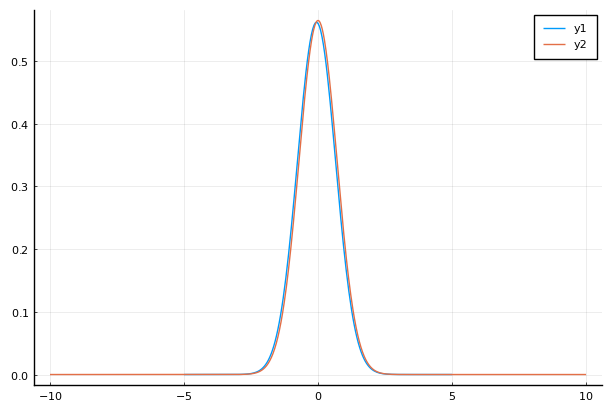

┌ Info: Saved animation to 
│   fn = /home/richard/Documents/Notebooks/ExamplesFolder/tmp.gif
└ @ Plots /home/richard/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/home/richard/Documents/Notebooks/ExamplesFolder/tmp.gif")
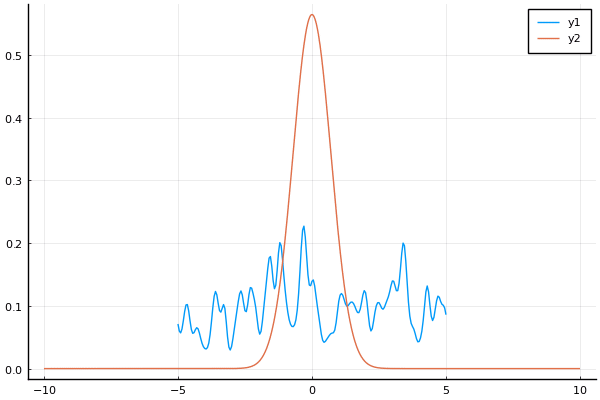

In [721]:
@gif for i = 1:300
    global psi0 = evolve_F(psi0,parMat,dt=1e-4,times=1e2)
    factor = sum(abs2.(psi0))*dx
    psi0 = psi0/sqrt(factor)
    plot([x_grid,x_range],[fftshift(abs2.(psi0)),abs2.(psi0s)])
end

In [602]:
factors= sum(abs2.(psi0s))*2e-2
psi0s = psi0s/sqrt(factors);

In [573]:
sum(abs2.(psi0s))*2e-2

1.0

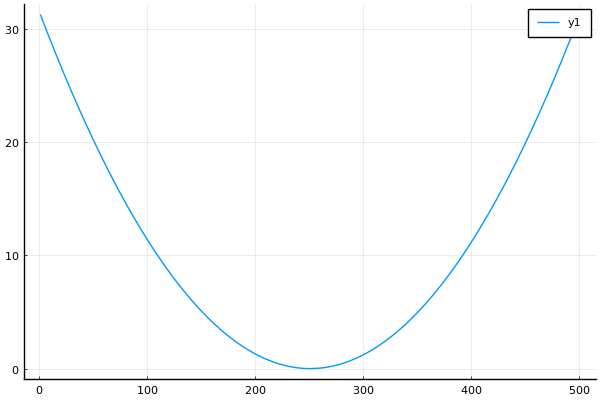

In [525]:
plot(V)

In [512]:
sum(abs2.(psi0))*dx

0.9999999999999996

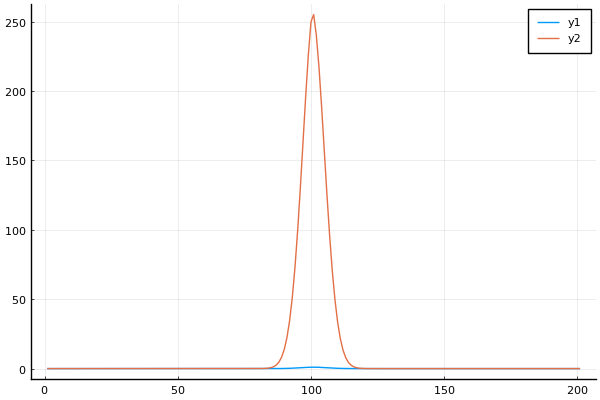

In [371]:
Hpsi0 = evolve_F(psi0,parMat,dt=0.0000001)
plot([abs2.(psi0),0.1*abs2.(Hpsi0)])

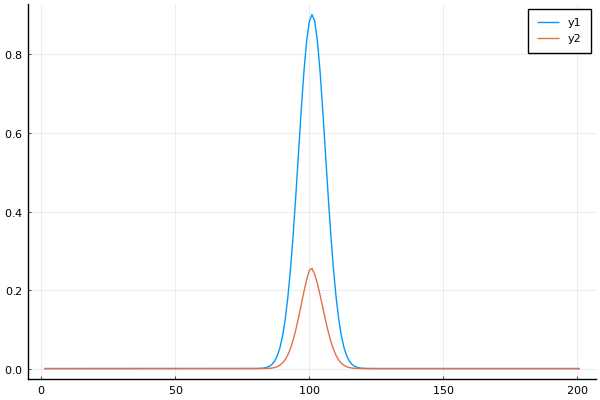

In [372]:
psi0 = psi0 - 1e-3.*Hpsi0
plot([abs2.(psi0),0.0001*abs2.(Hpsi0)])

In [422]:
psi0 = rand(N);

In [419]:
for i=1:10000
    Hpsi0 = evolve_F(psi0,parMat,dt=0.0000001)
    global psi0 = psi0 - 1im*1e-4 .* Hpsi0
    plot(abs2.(psi0))
end

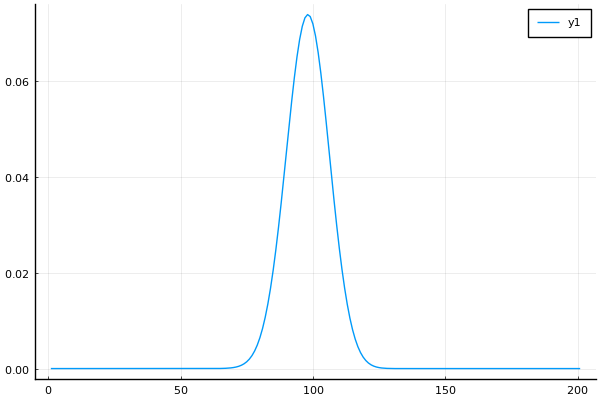

In [420]:
plot(fftshift(real.(psi0)))